In [1]:
from tools.game_tools import *
import matplotlib.pyplot as plt
%matplotlib inline
import gdown
import os.path

Inside the `game_tools.py` file, you can find the `Board()` class: one of its outputs is the game grid, created for the purpose of being able to play a game or observe its simulation. It also contains a bunch of vectors that are used to store all the useful information about the *board state*, such as the number of possible moves left, the number of valid moves and so on.\
All this information will later be used by the `Player()`'s children classes to make the decision about the next move.

The `Game()` object instantiates the game itself: the most important argument is the `game_type` argument, which selects the two participants in the game, whether human or algorithmic.

In [2]:
user_game_try = Game(game_type='user-user', verbose=True, player1='John', player2='Anna')

Game Type: user-user
Player #1: John, Human
Player #2: Anna, Human


In the cell below, you can challenge a friend in a classic game of *Connect4*.

In [3]:
user_game_try.play_game()

The WINNER is John, Human!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |     |     |     |  X  |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |  O  |  O  |  X  |  O  |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |  O  |  X  |  X  |  X  |  O  |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  O  |  O  |  X  |  X  |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


By using the `save_game()` method, the whole game (sequence of the board states) is stored inside a Pandas Dataframe. As you can see, it is composed of 9 columns plus the index column, which just represents the turn number.\
\
Note that the *choice* column contains the player's choice on the board state represented along the same row, meaning that its effect on the board can be seen only in the following row.\
I decided to use this structure with the training of future ML models in mind: since the goal is for the model to produce a choice, we must imagine that it can only have data from the past to do so.\
Using as a feature a board state that has already been affected by a choice not yet made would be like looking into the future.

In [4]:
df = user_game_try.save_game()
df.head()

,player,choice,col_0,col_1,col_2,col_3,col_4,col_5,col_6
0,John,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,Anna,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,John,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,Anna,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,John,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


The `simulation()` function repeats the same process $n$ times. The goal is to simulate $n$ games played by autonomous systems.\
It also rearranges the indexing, so that each game has a unique index and the turn number as before, ending with 10 total columns.\
Note that the function avoids those games that end in a draw, since we are going to use only winning moves to train the algorithm.

In [5]:
# default save_json=False
dataset = simulation(n=100, game_type='random-random')

Simulating:   0%|               | 0/100 [00:00<?, ?it/s]

Simulating: 100%|███████████████| 100/100 [00:00<00:00, 132.74it/s]


In [6]:
dataset.head()

,player,move,choice,col_0,col_1,col_2,col_3,col_4,col_5,col_6
0,RandomAI_1,0,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0,RandomAI_2,1,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0,RandomAI_1,2,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0,RandomAI_2,3,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
0,RandomAI_1,4,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, -1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


Now let's explore the dataset (actually, a larger dataset simulated earlier) a bit.\
For example, let's start with plotting the distribution of the moves number.

In [7]:
# getting a bigger pre-saved dataset
if len(dataset.index.unique()) < 10_000:
    dataset = read_json('simulations/simulation_random-random_10000.json')

In [8]:
# exactly n simulations, none of them ending in a draw
len(dataset.index.unique())

10000

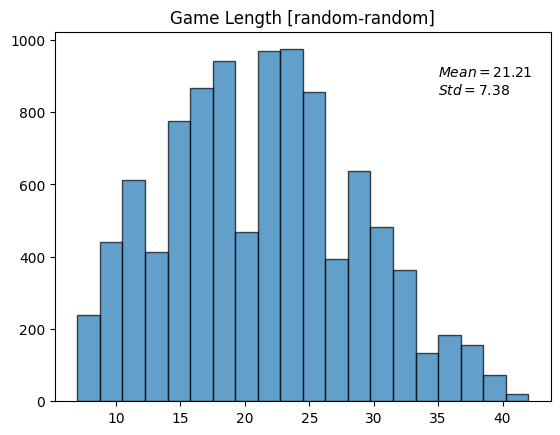

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42], dtype=int64)

In [13]:
row_count = dataset.groupby(level=0).size()

plt.hist(row_count, bins=20, alpha=0.7, edgecolor='black', linewidth=1)
plt.title('Game Length [random-random]')
plt.text(35, 900, f'$Mean = {row_count.mean().round(2)}$')
plt.text(35, 850, f'$Std = {row_count.std().round(2)}$')
plt.show()

np.sort(row_count.unique())

As expected, the absolute frequency follows a Poisson distribution, with the minimum value being 7.\
\
We now check whether one player won more times than the other, and also whether being the initial player may have provided an advantage on the final outcome of the match.

In [14]:
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

In [15]:
for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

RandomAI_1 winrate =  0.5094
RandomAI_2 winrate =  0.4906
Starter winrate  =  0.5562


The random players' winrates are basically identical, while it seems that starting the game first can give a certain advantage.\
\
Now you can try to play a game against this random-playing opponent, called *Randy*. The goal is to train a neural network that ultimately provides a much more stimulating level of challenge than *Randy*.\
\
*__Note__: when playing against any autonomous player, remember to set the arguments `pause=True` and `verbose=True`, otherwise the opponent's choice won't be displayed. Just press any key to display its choice during the game.*

In [10]:
play_game = Game(game_type='user-random', verbose=True, pause=True, player1='John', player2='Randy')

Game Type: user-random
Player #1: John, Human
Player #2: Randy, RandomAI


In [11]:
play_game.play_game()

The WINNER is John, Human!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |     |     |  X  |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |     |  O  |  X  |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |  O  |  X  |  X  |  O  |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  X  |  X  |  O  |  O  |     |  O  |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


Now let's give a brief demonstration of the `SimplePlayer()` class, which implements the strategy described in the `player_tools.py` file inside the `tools` folder.

In [18]:
dataset = simulation(n=100, game_type='simple-random')
# getting a bigger pre-saved dataset
if len(dataset.index.unique()) < 10_000:
    dataset = read_json('simulations/simulation_simple-random_10000.json')

Simulating:   0%|               | 0/100 [00:00<?, ?it/s]

Simulating: 100%|███████████████| 100/100 [00:00<00:00, 145.47it/s]


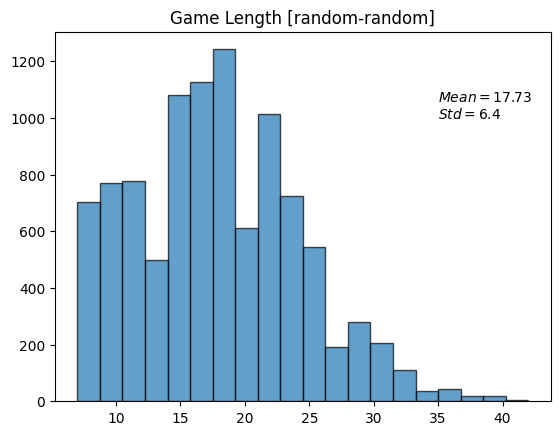

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42], dtype=int64)

In [19]:
row_count = dataset.groupby(level=0).size()

plt.hist(row_count, bins=20, alpha=0.7, edgecolor='black', linewidth=1)
plt.title('Game Length [random-random]')
plt.text(35, 1060, f'$Mean = {row_count.mean().round(2)}$')
plt.text(35, 1000, f'$Std = {row_count.std().round(2)}$')
plt.show()

np.sort(row_count.unique())

The mean and standard deviation of the distribution are definitely smaller than before: in this simulated dataset the games last less moves in average, and the consistency is higher.

In [20]:
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

In [21]:
for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

SimpleAI_1 winrate =  0.9126
RandomAI_2 winrate =  0.0874
Starter winrate  =  0.5118


As you can see, just by implementing a very simple strategy we have obtained an incredible player when compared to the *random* one. If you want a more challenging game, try a game against *Simply*, the `SimplePlayer()` opponent.

In [12]:
play_game = Game(game_type='user-simple', verbose=True, pause=True, player1='John', player2='Simply')
play_game.play_game()

The WINNER is Simply, SimpleAI!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |  O  |  X  |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |  O  |  O  |  X  |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |  X  |  X  |  X  |  O  |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |  X  |  X  |  X  |  O  |     |     |  O  |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  X  |  O  |  O  |  O  |  O  |  O  |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


Now it's time to get to the core of the project: training a Recurrent Neural Network to learn to play the game with a simulated dataset. We are going to use the dataset produced by two `SimplePlayer()` agents playing against each other.\
To make the Network learn a robust winning strategy, we want to train it using only the moves made by the winner of the game: the `prepare_dataset()` function takes care of exactly that.

In [24]:
if not os.path.isfile('simulations/simulation_simple-simple_100000.json'):
    url = 'https://drive.google.com/uc?id=1zjc7yvPHA03PpUx9RZ_HHSXPOIMk_jVh'
    output = 'simulations/simulation_simple-simple_100000.json'
    gdown.download(url, output, quiet=False)

    dataset = read_json(output)

Simulating: 100%|███████████████| 100/100 [00:00<00:00, 107.80it/s]


Before transforming the dataset into a Tensorflow dataset, we have to fix the issue with the length difference between different games. We use sequences that are long just as the mean length of the simulated games.\
However, some of them are shorter and we cannot use different-sized sequences to create a Tensorflow dataset. Then, we need to implement __*0-padding*__, that is, manually filling the missing values with useless data, such as rows with an empty board and a fixed move: on an empty board, we suppose that the best choice is to put the token in column 0.\
For example, if a sequence is shorter by 3 elements, we then add 3 empty boards with the same choice (column 0) to the sequence itself\
\
We also batch this dataset in equally-sized batches, each of them corresponding to the last $n$ moves of a game.

In [25]:
dataset = df_to_tensor(dataset)

The `quickdraw_dataset()` function has the aim of quickdrawing the final dataset - to be used with the neural network - from the tensor created from the dataframe.

In [33]:
dataset = quickdraw_dataset(dataset, shuffle_buffer_size=50)

Before proceeding with the RNN training, I would like to emphasise the data structure we have obtained.\
The final dataset is a tensor of size $N_{batches}$ where $N_{batches}$ is the total number of batches. Each of these batches contains $N_{games}$ board state sequences, each of them associated to the winning move made in the simulation (called *choice* in the previous dataset). Each of these sequences contains $N_{moves}$ last winning moves for each game (this quantity corresponds to the average duration of the matches in the entire dataset).\
Therefore, each feature's shape can be represented as follows:
<center>

$$shape = (N_{games}, N_{moves}, N_{columns} \times N_{rows})$$

In [34]:
# sequence of board states (for the 1st batch)
for features, targets in dataset.take(1):
    features = features.numpy()
    shape = features.shape
print(shape)

(32, 21, 42)


In [35]:
# will be useful later for playing with the RNN
mean_duration = shape[1]
print('Mean duration of the games the RNN will be trained on: ', mean_duration)

Mean duration of the games the RNN will be trained on:  21


In [36]:
# sequence of moves made on the previous group of board states
for features, targets in dataset.take(1):
    targets = targets.numpy()
print(targets.shape)

(32,)


Now it's time to split the dataset into a training set and a validation set. We don't need the test set since the final metric to evaluate the model's performance will be calculated from a number of simulated games between `RNNPlayer()` and `SimplePlayer()`.

In [37]:
dataset_size = len(list(dataset))

val_size = int(0.2 * dataset_size)
val_ds = dataset.take(val_size)
train_ds = dataset.skip(val_size)

In [38]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, kernel_size=6, strides=2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    return model

model = create_model()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True
)
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-2, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
# model's architecture
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 32)          6752      
                                                                 
 batch_normalization_6 (Batc  (None, None, 32)         128       
 hNormalization)                                                 
                                                                 
 conv1d_7 (Conv1D)           (None, None, 64)          6208      
                                                                 
 batch_normalization_7 (Batc  (None, None, 64)         256       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 7)                

In [39]:
history = model.fit(train_ds, epochs=20,
                    validation_data=val_ds,
                    callbacks=[early_stopping_cb])

Epoch 1/20
2500/2500 [==============================] - 24s 8ms/step - loss: 1.7051 - accuracy: 0.3204 - val_loss: 1.4169 - val_accuracy: 0.4564
Epoch 2/20
2500/2500 [==============================] - 23s 9ms/step - loss: 1.1925 - accuracy: 0.5543 - val_loss: 0.9348 - val_accuracy: 0.6610
Epoch 3/20
2500/2500 [==============================] - 26s 10ms/step - loss: 0.8692 - accuracy: 0.6868 - val_loss: 0.7504 - val_accuracy: 0.7305
Epoch 4/20
2500/2500 [==============================] - 23s 9ms/step - loss: 0.7223 - accuracy: 0.7436 - val_loss: 0.6535 - val_accuracy: 0.7680
Epoch 5/20
2500/2500 [==============================] - 22s 9ms/step - loss: 0.6367 - accuracy: 0.7757 - val_loss: 0.6014 - val_accuracy: 0.7919
Epoch 6/20
2500/2500 [==============================] - 22s 9ms/step - loss: 0.5795 - accuracy: 0.7975 - val_loss: 0.5634 - val_accuracy: 0.8048
Epoch 7/20
2500/2500 [==============================] - 23s 9ms/step - loss: 0.5393 - accuracy: 0.8117 - val_loss: 0.5216 - val_a

<Figure size 500x300 with 0 Axes>

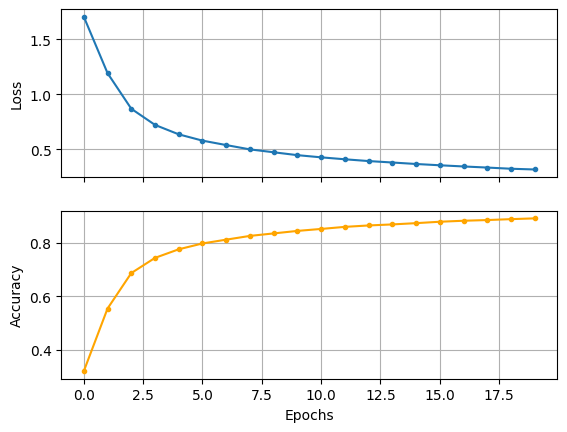

In [42]:
# plot the learning curves
plt.figure(figsize=(5,3))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(history.history['loss'], marker='.')
ax2.plot(history.history['accuracy'], marker='.', color='orange')

ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.xlabel('Epochs')
ax1.grid(True)
ax2.grid(True)

In [43]:
# unfortunately, we always have to pass an entire batch to the model predictor
# then, appending the desired sequence at the end of the batch, we can get the prediction's
# result by using index slicing on the numpy array
test_set = df_to_tensor(simulation(n=200, game_type='simple-simple', save_json=False))
test_set = quickdraw_dataset(test_set, shuffle_buffer_size=50)

probas = model.predict(test_set)

Simulating: 100%|███████████████| 200/200 [00:01<00:00, 100.24it/s]


7/7 [==============================] - 1s 3ms/step


In [44]:
save_model(model, 'models/1st_model')

Model saved succesfully.


In [19]:
from tools.game_tools import *
model = load_model('models/1st_model')

Model succesfully loaded.


In [14]:
# remember to always compile the model after loading it!
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-2, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Now let's test a simple match against this trained Recurrent Neural Network. We don't expect it to be very good, but maybe it learned something from the previous dataset.

In [16]:
play_game = Game(game_type='user-rnn', verbose=True, pause=True, player1='John', player2='Recurry', model=model)
play_game.play_game(mean_duration=21)

The WINNER is Recurry, RecurrentAI!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |  O  |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |  O  |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |  X  |  O  |  X  |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |  X  |  X  |  O  |     |  X  |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  X  |  X  |  O  |  O  |  O  |  O  |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


Now let's run a simulation with many games between the RNN player and the Random Player and see if the network has learned a strategy at least better than the random one.\
Then, repeat the same process also for the RNN player and the Simple one.

In [48]:
dataset = read_json('simulations/simulation_rnn-random-1_1000.json')

In [49]:
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

In [50]:
for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

RecurrentAI_1 winrate =  0.741
RandomAI_2 winrate =  0.259
Starter winrate  =  0.557


In [51]:
dataset = read_json('simulations/simulation_rnn-simple-1_1000.json')
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

SimpleAI_2 winrate =  0.601
RecurrentAI_1 winrate =  0.399
Starter winrate  =  0.573


Now it's time to train the network on another dataset: a dataset built with many games between the Simple player and the Random one: the goal is to make the RNN learn more specific winning moves made by the Simple player.

In [52]:
if not os.path.isfile('simulations/simulation_simple-random_100000.json'):
    url = 'https://drive.google.com/uc?id=1skoFBoe62hGo6vuK5fxoybhIvabKD3u-'
    output = 'simulations/simulation_simple-random_100000.json'
    gdown.download(url, output, quiet=False)

    dataset = read_json(output)

In [53]:
dataset = df_to_tensor(dataset)

In [54]:
dataset = quickdraw_dataset(dataset, shuffle_buffer_size=50)

In [55]:
# sequence of board states (for the 1st batch)
for features, targets in dataset.take(1):
    features = features.numpy()
    shape = features.shape
print(shape)

(32, 17, 42)


In [57]:
# will be useful later for playing with the RNN
mean_duration = shape[1]
print('Mean duration of the games the RNN will be trained on: ', mean_duration)

Mean duration of the games the RNN will be trained on:  17


In [58]:
dataset_size = len(list(dataset))

val_size = int(0.2 * dataset_size)
val_ds = dataset.take(val_size)
train_ds = dataset.skip(val_size)

In [59]:
# same model as before
model = create_model()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, restore_best_weights=True
)
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-2, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [60]:
history = model.fit(train_ds, epochs=20,
                    validation_data=val_ds,
                    callbacks=[early_stopping_cb])

Epoch 1/20
2500/2500 [==============================] - 23s 8ms/step - loss: 1.3372 - accuracy: 0.5106 - val_loss: 0.9891 - val_accuracy: 0.6579
Epoch 2/20
2500/2500 [==============================] - 18s 7ms/step - loss: 0.9076 - accuracy: 0.6877 - val_loss: 0.7849 - val_accuracy: 0.7329
Epoch 3/20
2500/2500 [==============================] - 18s 7ms/step - loss: 0.7624 - accuracy: 0.7402 - val_loss: 0.6923 - val_accuracy: 0.7625
Epoch 4/20
2500/2500 [==============================] - 19s 8ms/step - loss: 0.6847 - accuracy: 0.7677 - val_loss: 0.6324 - val_accuracy: 0.7846
Epoch 5/20
2500/2500 [==============================] - 18s 7ms/step - loss: 0.6276 - accuracy: 0.7865 - val_loss: 0.5842 - val_accuracy: 0.8037
Epoch 6/20
2500/2500 [==============================] - 19s 7ms/step - loss: 0.5848 - accuracy: 0.8015 - val_loss: 0.5621 - val_accuracy: 0.8110
Epoch 7/20
2500/2500 [==============================] - 19s 7ms/step - loss: 0.5513 - accuracy: 0.8135 - val_loss: 0.5343 - val_ac

<Figure size 500x300 with 0 Axes>

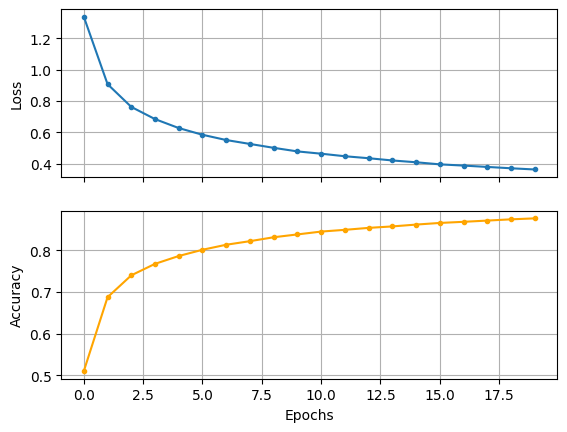

In [61]:
plt.figure(figsize=(5,3))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(history.history['loss'], marker='.')
ax2.plot(history.history['accuracy'], marker='.', color='orange')

ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.xlabel('Epochs')
ax1.grid(True)
ax2.grid(True)

In [62]:
save_model(model, 'models/2nd_model')

Model saved succesfully.


In [17]:
# remember to always compile the model after loading it!
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-2, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [18]:
play_game = Game(game_type='user-rnn', verbose=True, pause=True, player1='John', player2='Recurry', model=model)
play_game.play_game(mean_duration=17)

The WINNER is Recurry, RecurrentAI!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |  O  |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |  X  |  O  |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |  X  |  O  |  O  |  O  |  X  |  O  |     |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  X  |  X  |  O  |  O  |  X  |  X  |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


In [65]:
dataset = read_json('simulations/simulation_rnn-random-2_1000.json')

In [66]:
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

In [67]:
for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

RandomAI_2 winrate =  0.068
RecurrentAI_1 winrate =  0.932
Starter winrate  =  0.541


In [68]:
dataset = read_json('simulations/simulation_rnn-simple-2_1000.json')
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

RecurrentAI_1 winrate =  0.513
SimpleAI_2 winrate =  0.487
Starter winrate  =  0.565


The results on this second dataset are even better! We have obtained a player capable of outperforming the hard-coded startegy!
## Conclusion
Unfortunately, the available hardware for this project was not excellent, therefore I had to strongly limit the number of training instances, as well as the number of training epochs. At the same time, I could not do many attempts to tweak all the hyperparameters, since they were very time-consuming and very expensive in terms of computational power.\
However, the results I have obtained show a great potential for this recurrent approach to the game of Connect 4, since it was sufficient to give the RNN a dataset to make it learn a strategy that outperforms the random one.\
Furthermore, in the last part of the project, we discovered that we can train the RNN to learn and replicate the `SimplePLayer()` strategy, ending up being even better at the game.\
However, as mentioned also in the `player_tools.md` file, the RNN suffers from a problem associated to the difference between training sequences and on-line *playing* sequences: this issue makes the RNN's first few moves quite unintelligible from the point of view of a human player, since they are clearly not random but they also do not point towards winning the game.\
Despite being quite promising, I think that these results do not justify the usage of this kind of network in games, especially when compared to an algorithm of __Reinforcement Learning__ that is often able to outperform the human player.\
\
*__Possible Developments__*: of course one of the most interesting possible developments would be to incorporate the Reinforcement Learning approach, making the network train itself also while playing, and giving it a reward or a penalty (decreasing or increasing the cost function) for good or bad moves.\
Another possible improvement would be training the network on a much larger dataset (perhaps $10^6$ games) in order to make it learn from a wider variety of board states and take more consistent decisions.\
In fact even the best network we have obtained is pretty simple to defeat from a human perspective.